In [0]:
!pip install tvb-library
# imports
import warnings
warnings.filterwarnings('ignore')
import os, sys, scipy.io, numpy as np, seaborn as sns
from matplotlib import pyplot as plt
import timeit, time as tm
from tvb.simulator.lab import *
%matplotlib inline

from IPython.display import HTML
import zipfile
from scipy.io import loadmat, savemat
from google.colab import files

from tvb.datatypes.time_series import TimeSeriesRegion
import tvb.analyzers.correlation_coefficient as corr_coeff

# download data that we will need for this tutorial

# download Hagmann SC and FC
!wget https://raw.githubusercontent.com/amandakeasson/temp_tvb_tutorials/master/connectivity_HagmannDeco66.zip
!wget https://raw.githubusercontent.com/amandakeasson/temp_tvb_tutorials/master/Hagmann_empFC_avg.npy
zip_ref = zipfile.ZipFile('connectivity_HagmannDeco66.zip', 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

# Download simulation outputs
!wget https://raw.githubusercontent.com/amandakeasson/tvb_tutorials/master/sim_outputs.zip
zip_ref = zipfile.ZipFile('sim_outputs.zip', 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

print('\n\n\n successfully imported all packages')


--2019-05-14 20:53:48--  https://raw.githubusercontent.com/amandakeasson/temp_tvb_tutorials/master/connectivity_HagmannDeco66.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18839 (18K) [application/zip]
Saving to: ‘connectivity_HagmannDeco66.zip.1’

connectivity_Hagman 100%[===================>]  18.40K  --.-KB/s    in 0.004s  

2019-05-14 20:53:48 (4.59 MB/s) - ‘connectivity_HagmannDeco66.zip.1’ saved [18839/18839]

--2019-05-14 20:53:49--  https://raw.githubusercontent.com/amandakeasson/temp_tvb_tutorials/master/Hagmann_empFC_avg.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP r

<br>
<div align="center"><font size="7" face="calibri" color="#000099">Modelling Resting State Brain Dynamics</font></div>
<br>
<div align="center"><font size="7" face="calibri" color="#000099">using The Virtual Brain (TVB)</font></div>
<br><br>
<div align="center"><span style="font-weight:normal"><font size="4" face="calibri">Originally created by <b>John Griffiths</b> and <b>Julie Courtiol</b></font></span></div>
<br>
<div align="center"><span style="font-weight:normal"><font size="4" face="calibri">Modified for the CAN satellite workshop by <b>Amanda Easson</b> and <b>Kelly Shen</b></font></span></div>
<br><br>

---

<h2><font size="6" color="#609BC4" face="calibri">Contents</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">

<a href="#Overview">Overview</a>
<br>
<a href="#Setup">Setup</a>
<br>
<a href = "#Load-and-prepare-data">Load and prepare data</a>
<br>
<a href = "#Computational-model">Computational model</a>
<br>
<a href = "#Optimal-working-reigon-of-the-model">Optimal working region of the model</a>
<br>
<a href = "#Compute-FC-for-the-best-working-point">Compute FC for the best working point</a>
<br>
<a href = "#Conclusions">Conclusions</a>
<br>
<a href = "#References">References</a>

</font></div></p>

---

<h2><font size="6" face="calibri" color="#609BC4">Overview</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="calibri">
A current topic in system neuroscience literature is the presence of brain activity in the absence of a task condition. These spontaneous fluctuations occur in the so-called <b>rest state</b>, and a recurring theme of these fluctuations is that they have a network structure. Because TVB uses the <b>structural connectivity</b> of the brain as the backbone for simulating spontaneous activity, resting-state activity and its network structure is a prime candidate for modeling in TVB. </font></div></p>


<p><div style="text-align: justify"><font size="4.5" face="calibri">

In this tutorial, we will:
<br>
<ul>
    <li>build a resting brain model using subject-specific structural connectivity (SC), defined using probalistic tractography, </li> 
    <li>generate its resting-state fMRI BOLD signals,</li>
    <li>identify the dynamical working region of the model,</li>
     <li>perform a parameter space exploration to identify regions of improved correlations between simulated and empirical functional connectivity (FC).</li>
        </ul>
        
</font></div></p>

---

<h2><font size="6" face="calibri" color="#609BC4">Setup</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="calibri">
  First, we will need to install the <b>tvb-library</b> package for Python. </font></div></p>

In [0]:
# install tvb library
!pip install tvb-library

     |████████████████████████████████| 512kB 8.6MB/s 
     |████████████████████████████████| 51kB 25.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/f3/28/a4/fef64ac14300b6b1c231bb472f5ae3516e6d4a42340303dccb
Successfully built tvb-gdist


<p><div style="text-align: justify"><font size="4.5" face="calibri">
We will now import the Python packages that we need for the simulations and visualizations </font></div></p>

In [0]:
# imports
import warnings
warnings.filterwarnings('ignore')
import os, sys, scipy.io, numpy as np, seaborn as sns
from matplotlib import pyplot as plt
import timeit, time as tm
from tvb.simulator.lab import *
%matplotlib inline
sns.set()

from IPython.display import HTML
import zipfile
from scipy.io import loadmat, savemat
from google.colab import files

from tvb.datatypes.time_series import TimeSeriesRegion
import tvb.analyzers.correlation_coefficient as corr_coeff


/usr/local/lib/python2.7/dist-packages/tvb/simulator/lab.py:46: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "</usr/local/lib/python2.7/dist-packages/decorator.pyc:decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages

<p><div style="text-align: justify"><font size="4.5" face="calibri">
TVB simulations can take a while to run. In this tutorial we will show you how to run the simulations, but we won't actually run them. Instead, we will load the results from simulations that we ran beforehand. Run the following cell to download the data that we will be using for today's tutorial. </font></div></p>

In [0]:
# download data that we will need for this tutorial

# download Hagmann SC and FC
!wget https://raw.githubusercontent.com/amandakeasson/temp_tvb_tutorials/master/connectivity_HagmannDeco66.zip
!wget https://raw.githubusercontent.com/amandakeasson/temp_tvb_tutorials/master/Hagmann_empFC_avg.npy
zip_ref = zipfile.ZipFile('connectivity_HagmannDeco66.zip', 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

# Download simulation outputs
!wget https://raw.githubusercontent.com/amandakeasson/tvb_tutorials/master/sim_outputs.zip
zip_ref = zipfile.ZipFile('sim_outputs.zip', 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

--2019-05-14 19:55:27--  https://raw.githubusercontent.com/amandakeasson/temp_tvb_tutorials/master/connectivity_HagmannDeco66.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18839 (18K) [application/zip]
Saving to: ‘connectivity_HagmannDeco66.zip’

connectivity_Hagman 100%[===================>]  18.40K  --.-KB/s    in 0.003s  

2019-05-14 19:55:28 (5.34 MB/s) - ‘connectivity_HagmannDeco66.zip’ saved [18839/18839]

--2019-05-14 19:55:29--  https://raw.githubusercontent.com/amandakeasson/temp_tvb_tutorials/master/Hagmann_empFC_avg.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP reque

---

<h2><font size="6" face="calibri" color="#609BC4">Load and prepare data</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="calibri">
Here, we use a <b>Structural Connectivity (SC) of 66 regions</b> derived from Diffusion Spectrum Imaging (DSI) and tractography, as previously published in <b>Hagmann et al. (2008)</b> with the modifications introduced by <b>Cabral et al. (2011)</b>. Connections in this SC matrix were defined with a standard parcellation scheme (<b>Desikan et al., 2006</b>), and averaged over 5 healthy right-handed male human subjects.
</font></div></p> 

<p><div style="text-align: justify"><font size="4.5" face="calibri">

We use a <b>resting-state Functional Connectivity (FC)</b> obtained from the same 5 human subjects and using the same 66 cortical areas adopted for the SC above. The resting-state FC is calculated by measuring the corresponding <b>fMRI BOLD signals</b> during the entire duration of <b>20 min</b>.

</font></div></p>

In [0]:
Hag_con = connectivity.Connectivity.from_file('connectivity_HagmannDeco66.zip')
nregions = len(Hag_con.region_labels)     #number of regions
Hag_con.speed = np.inf                    #set the conduction speed to infinity => no time delays
Hag_con.configure()
Hag_SC = Hag_con.weights
Hag_tract_lengths = Hag_con.tract_lengths

Hag_FC = np.load('Hagmann_empFC_avg.npy')

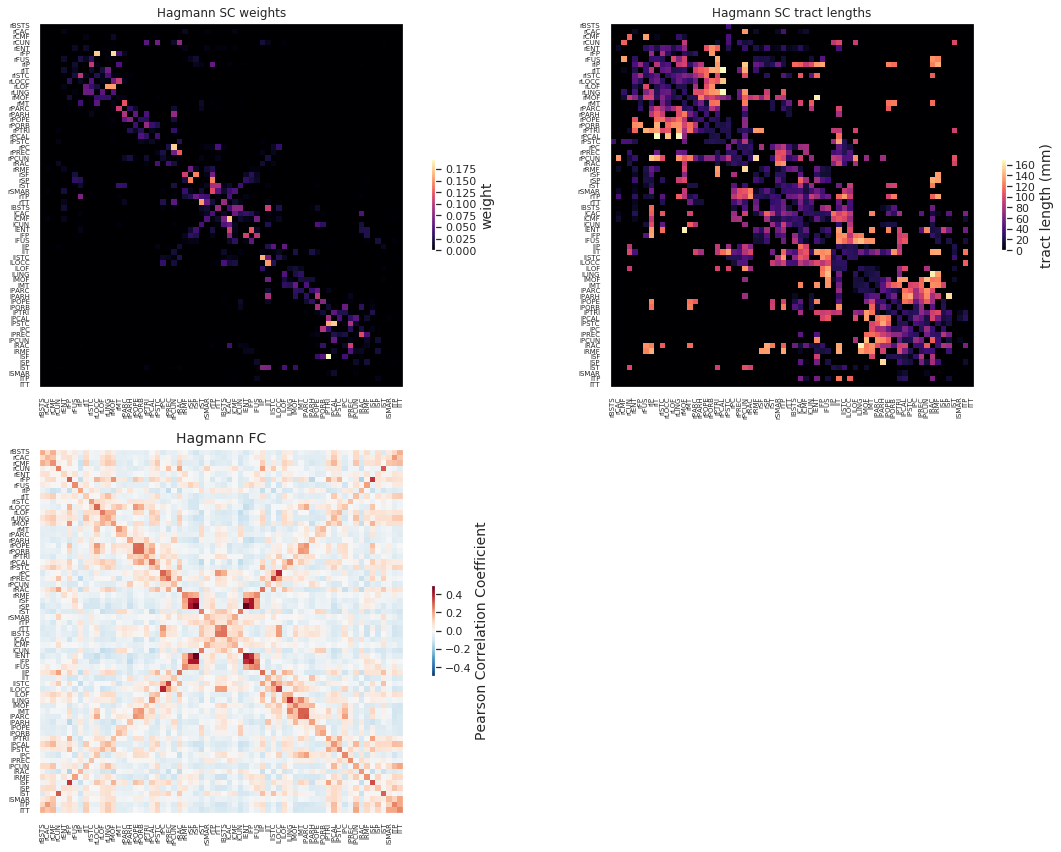

In [0]:
# Visualization
fig=plt.figure(figsize=(16,12))

# weights
plt.subplot(221)
plt.imshow(Hag_con.weights, interpolation='nearest', aspect='equal', cmap='magma')
plt.grid('off')
plt.xticks(range(0, nregions), Hag_con.region_labels, fontsize=7, rotation=90)
plt.yticks(range(0, nregions), Hag_con.region_labels, fontsize=7)
cb=plt.colorbar(shrink=0.25)
cb.set_label('weight', fontsize=14)
plt.title('Hagmann SC weights')

#tracts
plt.subplot(222)
plt.imshow(Hag_con.tract_lengths, interpolation='nearest', aspect='equal', cmap='magma')
plt.grid('off'); 
plt.xticks(range(0, nregions), Hag_con.region_labels, fontsize=7, rotation=90)
plt.yticks(range(0, nregions), Hag_con.region_labels, fontsize=7)
cb=plt.colorbar(shrink=0.25)
cb.set_label('tract length (mm)', fontsize=14)
plt.title('Hagmann SC tract lengths')

# FC
plt.subplot(223)
plt.imshow(Hag_FC, interpolation='nearest', aspect='equal', 
           cmap='RdBu_r', vmin=-.5, vmax=.5)
plt.grid('off')
plt.xticks(range(0, nregions), Hag_con.region_labels, fontsize=7, rotation=90)
plt.yticks(range(0, nregions), Hag_con.region_labels, fontsize=7)
cb=plt.colorbar(shrink=0.25)
cb.set_label('Pearson Correlation Coefficient', fontsize=14)
plt.title('Hagmann FC', fontsize=14)

fig.tight_layout()
plt.show()

<h3><font size="5" face="calibri" color="black">SC-FC comparison</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="calibri">

We compare the SC and FC matrix of the empirical data by adopting as a measure of similarity between the two matrices the Pearson correlation between corresponding elements of the <b>upper (or lower)</b> triangular part of the matrices.

</font></div></p>

In [0]:
# Take upper triangular part of the matrices (excluding the self-connections).
Hag_SC_triu = np.triu(Hag_SC, 1)
Hag_FC_triu = np.triu(Hag_FC, 1)

# Compute Pearson correlation coefficients between SC and FC.
pcc = np.corrcoef(Hag_SC_triu.ravel(), Hag_FC_triu.ravel())[0, 1]
print 'Correlation between Hagmann SC and FC:', round(pcc,2)

Correlation between Hagmann SC and FC: 0.39


---

<h2><font size="6" face="calibri" color="#609BC4">Computational model</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="calibri">In this tutorial, we will use a computational model of resting-state network dynamics: the <b>enhanced non-linearity mean field model (eMFM)</b>, previously introduced in <b>(Hansen et al., 2015)</b>. This model is a reduction of the model presented in <b>(Wong &#38; Wang, 2006)</b> to a single population model and used in a modeling study of resting-state <b>(Deco et al., 2013; Hansen et al., 2015)</b>. The neural activity of each node is given by the following equations:</font></div></p>

\begin{eqnarray}
    \dfrac{\text{d}S_{i}}{\text{d}t} &=& \dfrac{-S_{i}}{\tau_{s}} + \gamma \ (1 - S_{i})\ H(x_{i}) + \sigma\eta_{i}(t)\\
    &\\
    H(x_{i}) &=& \dfrac{ax_{i} - b}{1 - \exp(-d \ (ax_{i} - b))}\\
    &\\
    x_{i} &=& wJ_{N}S_{i} + J_{N}G\sum_{j}C_{ij}S_{j} + I_{0}
\end{eqnarray}

<br>
<p><div style="text-align: justify"><font size="4.5" face="calibri">Below is a summary of the model parameters:</font></div></p>  
<br><br>

| Variable        | Definition           |
| :------------- |:-------------| 
| $S_{i}$   | average synaptic gating variable at the local area $i$ | 
| $H(x_{i})$      | sigmoid function that converts the input synaptic activity $x_{i}$ into an output population firing rate      |  
| $a = 0.270$ (nA.ms<sup>-1</sup>), $b = 0.108$ (kHz), $d = 154$ (ms) |  parameters of the input-output function $H$   |  
| $w = 1.0$ | local excitatory recurrence | 
| $\gamma = 0.641$, $\tau=100$ (ms) | kinetic parameters|
| $J_{N} = 0.2609$ (nA) | synaptic couplings
| $I_0 = 0.3$ (nA) | overall effective external input |
| $C_{ij}$ | entries of the anatomical SC matrix |
| $G$ | global coupling (reweights the SC) | 
| $\eta_{i}(t)$ | Gaussian white noise |
| $\sigma = 0.001$ | amplitude of Gaussian white noise |

<br><br>
<p><div style="text-align: justify"><font size="4.5" face="calibri">We will perform a parameter sweep of $G$ to study the optimal dynamical working region, where the simulated FC maximally fits the empirical FC.</font></div></p>
<br><br>

<h3><font size="5" face="calibri" color="black">Exploring the model</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="calibri">First, we initialize the model, and display the default parameters.</font></div></p>  

In [0]:
# Initialise the Model.
rww = models.ReducedWongWang()
HTML(rww._repr_html_() + "</table>") # fixes bug with nbconvert->HTML

I_o,[0.33]
a,[0.27]
b,[0.108]
d,[154.]
state_variable_range,"{'S': array([0., 1.])}"
J_N,[0.2609]
sigma_noise,[1.e-09]
w,[0.6]
variables_of_interest,['S']
tau_s,[100.]
gamma,[0.641]


<h3><font size="4" face="arial" color="black">Effects of the local excitatory recurrence</font></h3>

In [0]:
# Initialize the state-variable S
S = np.linspace(0., 1., num=1000).reshape((1, -1, 1))   

# Remember: the phase-flow only represents the dynamic behaviour of a disconnected node => SC = 0.
C = S*0.  

In [0]:
# Parameter sweep
W = np.linspace(0.6, 1.05, num=50)
# Fixed Io value
rww.I_o = 0.33

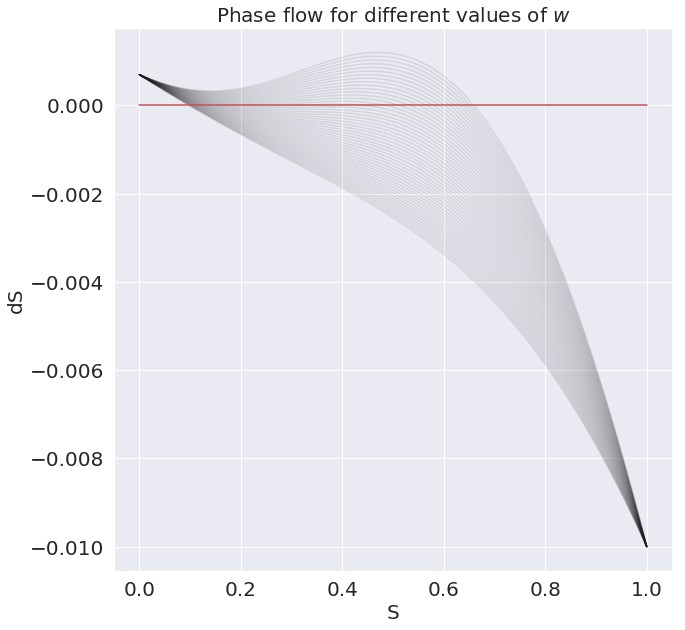

In [0]:
# Visualize phase-flow for different w values
fig = plt.figure(figsize=(10, 10))
for iw, w in enumerate(W):
    rww.w = w
    dS = rww.dfun(S, C)  
    plt.plot(S.flat, dS.flat, 'k', alpha=0.1)
plt.plot([0, 0] , 'r')    
plt.title('Phase flow for different values of $w$', fontsize=20)
plt.xlabel('S', fontsize=20); plt.xticks(fontsize=20)
plt.ylabel('dS', fontsize=20); plt.yticks(fontsize=20)
plt.show()

<h3><font size="4" face="arial" color="black">Effects of the external input</font></h3>

In [0]:
# Parameter sweep
Io = np.linspace(0.00, 0.42, num=50)
# Fixed w value at 1
rww.w = 1

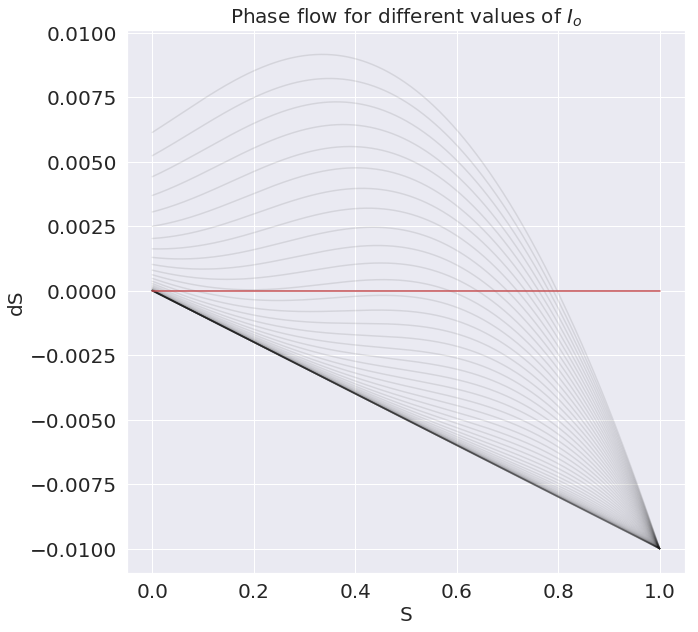

In [0]:
# Plot phase-flow for different Io values
fig = plt.figure(figsize=(10, 10))
for i, io in enumerate(Io):
    rww.I_o = io
    dS = rww.dfun(S, C)
    plt.plot(S.flat, dS.flat, 'k', alpha=0.1)
plt.plot([0, 0] , 'r')    
plt.title('Phase flow for different values of $I_o$', fontsize=20)
plt.xlabel('S', fontsize=20); plt.xticks(fontsize=20)
plt.ylabel('dS', fontsize=20); plt.yticks(fontsize=20)
plt.show()

<h3><font size="4" face="arial" color="black">Bifurcation diagram</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">

To identify the mechanisms underlying
resting-state generation, we will first study how the dynamics of the model depends on the global coupling strength
$G_{coupl}$, describing the scaling or global strength of the intercortical brain areas coupling. In that case, we will study the fixed points of the local model dynamics in the absence of noise. To this end, we will calculate the <b>bifurcation diagram</b> characterizing the stationarity states of the brain system.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We calculate firing rates $H(x)$ from synaptic activation variable $S$ returned by TVB, using the equation:</font></div></p>

\begin{eqnarray}
    H(x_{i}) &=& \dfrac{ax_{i} - b}{1 - \exp(-d \ (ax_{i} - b))}\\
    &\\
    x_{i} &=& wJ_{N}S_{i} + J_{N}G\sum_{j}C_{ij}S_{j} + I_{0}
\end{eqnarray}

<p><div style="text-align: justify"><font size="4.5" face="time roman">
We have to do this manually as TVB doesn't give these numbers by default, although it does calculate them on each integration step using the equation above.
</font></div></p>

In [0]:
def run_rww_sim_bif(con, G, regime, D, dt, simlen, initconds):
    # Initialise Simulator.
    sim = simulator.Simulator(
        model=MyRWW(**regime),
        connectivity=con,
        coupling=coupling.Scaling(a=np.float(G)),
        integrator=integrators.HeunDeterministic(dt=dt),
        monitors=monitors.TemporalAverage(period=1.) 
    )
    # Set initial conditions.
    if initconds:
        if initconds == 'low':
            sim.initial_conditions = np.random.uniform(low=0., high=0.2, size=((1, 1, nregions, 1)))
        elif initconds == 'high':   
            sim.initial_conditions = np.random.uniform(low=0.8, high=1.0, size=(1, 1, nregions, 1))
    
    sim.configure()
    # Lunch simulation
    H = []
    for (t, y), in sim(simulation_length=simlen):
        H.append(sim.model.H.copy())
        
    H = np.array(H)
    Hmax = np.max(H[14999, :])
    return Hmax

In [0]:
class MyRWW(models.ReducedWongWang):
    def dfun(self, state, coupling, local_coupling=0.0):
        # save the x and H value as attribute on object
        S, = state
        c_0, = coupling
        lc_0 = local_coupling * S
        self.x = self.w * self.J_N * S + self.I_o + self.J_N * c_0 + self.J_N * lc_0
        self.H = (self.a*self.x - self.b) / (1 - np.exp(-self.d*(self.a*self.x - self.b)))
        # call the default implementation
        return super(MyRWW, self).dfun(state, coupling, local_coupling=local_coupling)

The cell below shows you how to run the simulations. We will skip this cell for this tutorial; instead, we will load the results from these simulations.

In [0]:
%%time
tic = tm.time()

regime = {'a': 270., 'b':108., 'd':0.154, 'gamma':0.641/1000, 'w':1., 'I_o':0.3}

# Run G sweep with short runs
Gs = np.arange(0., 3.1, 0.1)

Hmax_low = np.zeros((len(Gs)))
Hmax_high = np.zeros((len(Gs)))
for iG, G in enumerate(Gs):
    Hmax_low[iG] = run_rww_sim_bif(Hag_con, np.float(Gs[iG]), regime, 0.001, 0.1, 15000,'low')
    Hmax_high[iG] = run_rww_sim_bif(Hag_con, np.float(Gs[iG]), regime, 0.001, 0.1, 15000,'high')
    
'simulation required %0.f seconds.' % (tm.time()-tic)

CPU times: user 20min 52s, sys: 361 ms, total: 20min 53s
Wall time: 20min 53s


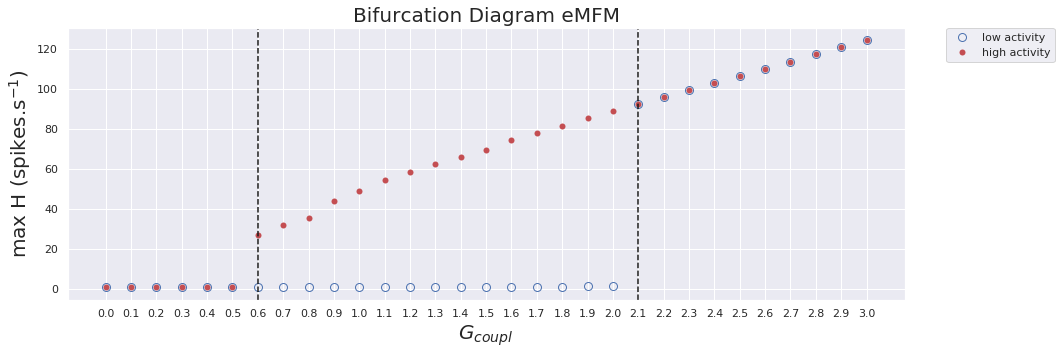

In [0]:
# Load results

mat = loadmat('sim_outputs/bifurcation_eMFM.mat')
Hmax_low = mat['Hmax_low'].T
Hmax_high = mat['Hmax_high'].T
Gs = np.arange(0.0, 3.1, 0.1)

# Visualization of the bifurcation diagram
plt.figure(figsize=(15, 5))
# plot low activity
plt.plot(np.arange(31), Hmax_low, 'o', markeredgecolor='b', markerfacecolor='none', markersize=8, label='low activity')
# plot high activity
plt.plot(np.arange(31), Hmax_high, 'ro', markeredgecolor='none', label='high activity')
plt.title('Bifurcation Diagram eMFM', fontsize=20)

plt.xticks(np.arange(len(Gs)), np.round(Gs,2))
plt.xlabel('$G_{coupl}$', fontsize=20); plt.ylabel('max H (spikes.s$^{-1}$)', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# critical points
plt.axvline(6, color='k', linestyle='--')
plt.axvline(21, color='k', linestyle='--')

plt.savefig('bifurcation_diagram.png')
plt.show()

files.download('bifurcation_diagram.png')

<p><div style="text-align: justify"><font size="4.5" face="time roman">The key features that is shown in the bifurcation diagram, above, is the existence of <b>3 separate regimes</b>:</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">
<ul>
<li>for <b>small values</b> of the global coupling $G_{coupl}$, only <b>one stable state</b> (i.e., spontaneous state) exists, characterizing by a low firing activity in all cortical areas, </li>
<li>for a critical value of $G_{coupl}$ (at $0.6$), a <b>first bifurcation</b> emerges where a new <b>multistable state</b> appears with multiple attractors and <b>higher activity</b>, while the state of low activity remains stable,</li>
<li>for even larger values of $G_{coupl}$, a <b>second bifurcation</b> appears at $G_{coupl} = 2.$, characterized by a loss of stability in the spontaneous state.</li></font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">In the following, we will seek to identify the parameter regimen in which the emergent model FC matches the empirical one.</font></div></p>

---

<h2><font size="6" color="#609BC4">Optimal working region of the model</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">To identify the region of the parameter <i>G</i> where the model best reproduces the empirical functional connectivity, we will convolve the simulated neuronal activity <i>S<sub>i</sub></i> with the <b>canonical hemodynamic response function</b> (implemented with a gamma kernel) with a sampling frequency of <b>0.5 Hz</b> using the <b>monitor BOLD</b> already implemented in TVB. And finally, we will compute the simulated functional connectivity by calculating the correlation matrix of the BOLD activity between all brain areas. We will compute the Pearson correlation between both the empirical and the simulated functional connectivity matrix.</font></div></p>

In [0]:
def run_rww_sim_pcc(con, G, regime, D, dt, simlen):
    
    # Initialise Simulator.
    sim = simulator.Simulator(
        model=models.ReducedWongWang(**regime),
        connectivity=con,
        coupling=coupling.Scaling(a=np.float(G)),
        integrator=integrators.HeunStochastic(dt=dt, noise=noise.Additive(nsig=np.array([(D**2)/2]))),
        monitors=monitors.Bold(period=2000.0) 
    )
    sim.initial_conditions = (0.001)*np.ones((1, 1, nregions, 1))
    sim.configure()
    
    # Launch simulation
    (t, B), = sim.run(simulation_length=simlen)
    
    # Remove transient time
    #B = B[10:simlen/2000, :, :, :]
    
    # Build a TimeSeries Datatype
    tsr = TimeSeriesRegion(connectivity=con,
                           data=B, 
                           sample_period=sim.monitors[0].period)
    tsr.configure()
    
    # Compute FC
    corrcoeff_analyser = corr_coeff.CorrelationCoefficient(time_series=tsr)
    corrcoeff_data = corrcoeff_analyser.evaluate()
    corrcoeff_data.configure()
    FC = corrcoeff_data.array_data[..., 0, 0]
    savemat('FC_' + str(G) + '_' + str(simlen) + '.mat', {'B': B, 'FC': FC})

    # Take triangular upper part of FC
    FC_triu = np.triu(FC, 1)
    
    # Compute Pearson correlation
    pcc_FC = np.corrcoef(Hag_FC_triu.ravel(), FC_triu.ravel())[0, 1]
    pcc_SC = np.corrcoef(Hag_SC_triu.ravel(), FC_triu.ravel())[0, 1]
    
    #return pcc
    return pcc_FC, pcc_SC

Again, the below cell illustrates how to run the simulations, but we will skip this cell and load the results directly.

In [0]:
%%time

#tic = tm.time()

# Run G sweep
Gs = np.arange(0., 3.1, 0.1)
regime = {'a': 270., 'b':108., 'd':0.154, 'gamma':0.641/1000, 'w':1., 'I_o':0.30}

pcc_FC = np.zeros((len(Gs)))
pcc_SC = np.zeros((len(Gs)))
for iG, G in enumerate(Gs):
    print(iG)
    pcc_FC[iG], pcc_SC[iG] = run_rww_sim_pcc(Hag_con, Gs[iG], regime, 0.001, 0.1, 60000) #60000 = 1min BOLD, 1230000 = 20.5min BOLD
    
#'simulation required %0.3f seconds.' % (tm.time()-tic)

In [0]:
Gs = np.arange(0., 3.1, 0.1)

pcc_FC = np.zeros((len(Gs)))
pcc_SC = np.zeros((len(Gs)))
for iG, G in enumerate(Gs):

  file2load = 'sim_outputs/FC_' + str(np.round(Gs[iG],2)) + '_1230000.mat'

  tmp = loadmat(file2load)
  B = tmp['B']
  B = np.squeeze(B[15:,:,:,:])
  FC_sim = np.corrcoef(B.T)
  
  if Gs[iG] == 2.1:
    FC_sim_best = FC_sim

  def fisherz(r):
    z = .5*(np.log(1+r) - np.log(1-r))
    return z

  inds = np.triu_indices(66,1)
  simFC_test = FC_sim[inds]
  empFC_test = Hag_FC[inds]
  empSC_test = Hag_SC[inds]
  pcc_FC[iG] = np.corrcoef(fisherz(simFC_test), fisherz(empFC_test))[0,1]
  pcc_SC[iG] = np.corrcoef(fisherz(simFC_test), fisherz(empSC_test))[0,1]

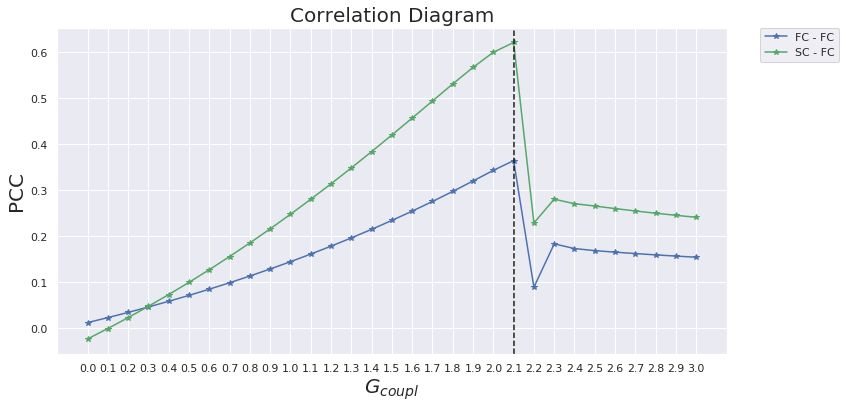

In [0]:
# Visualize 

plt.figure(figsize=(12,6))

# FC
plt.plot(pcc_FC, '-*', label='FC - FC')
plt.xlabel('$G_{coupl}$', fontsize=20); plt.xticks(np.arange(len(Gs)), np.round(Gs,2))
plt.ylabel('PCC', fontsize=20)

# SC
plt.plot(pcc_SC, '-*g', label='SC - FC')
plt.xlabel('$G_{coupl}$', fontsize=20); #plt.xticks(np.arange(len(Gs)), Gs)
plt.ylabel('PCC', fontsize=20)
plt.title('Correlation Diagram', fontsize=20)

plt.axvline(21, color='k', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('sim_emp_corr_diagram.png')
plt.show()

files.download('sim_emp_corr_diagram.png')

<p><div style="text-align: justify"><font size="4.5" face="time roman">

So, the best fit (maximal correlation) occurs exactly at the <b>edge of the second bifurcation</b>, where the spontaneous state loses its stability and, therefore, the noisy fluctuations of the dynamics are able to explore and reflect the structure of the other ‘cognitive’ attractors shaped by the underlying anatomy.

</font></div></p>

---

<h2><font size="6" color="#609BC4">Compute FC model for the best working point</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">
Here, we will simulate the FC matrix obtained at the best-fit critical point of the eMFM model for a long-run:
</font></div></p>

In [0]:
def run_rww_bestfit(con, G, regime, D, dt, simlen):
    # Initialise Simulator.
    sim = simulator.Simulator(
        model=models.ReducedWongWang(**regime), 
        connectivity=con,
        coupling=coupling.Scaling(a=G),
        integrator=integrators.HeunStochastic(dt=dt, noise=noise.Additive(nsig=np.array([(D**2)/2]))),
        monitors=(monitors.TemporalAverage(period=1.), monitors.Bold(period=2000.)))
    sim.initial_conditions = 0.001*np.ones((1, 1, nregions, 1))
    sim.configure()
    # Perform simulation
    (tavg_time, tavg_data), (bold_time, bold_data)= sim.run(simulation_length=simlen)
    # Discarded first 20s
    data = bold_data[10:simlen/2000]
    # Build a TimeSeries Dataype
    tsr = TimeSeriesRegion(connectivity=Hag_con,
                           data=data, 
                           sample_period=sim.monitors[1].period)
    tsr.configure()
    # Compute FC
    corrcoeff_analyser = corr_coeff.CorrelationCoefficient(time_series=tsr)
    corrcoeff_data = corrcoeff_analyser.evaluate()
    corrcoeff_data.configure()
    FC = corrcoeff_data.array_data[..., 0, 0]
    
    return FC

In [0]:
%%time 

#tic = tm.time()

FC = run_rww_bestfit(Hag_con, 2., {'w':1., 'I_o':0.3}, 0.001, 0.1, 360000)

#'simulation required %0.3f seconds.' % (tm.time()-tic)

   INFO  result shape will be: (66L, 66L, 1L, 1L)
Wall time: 1h 20min 29s


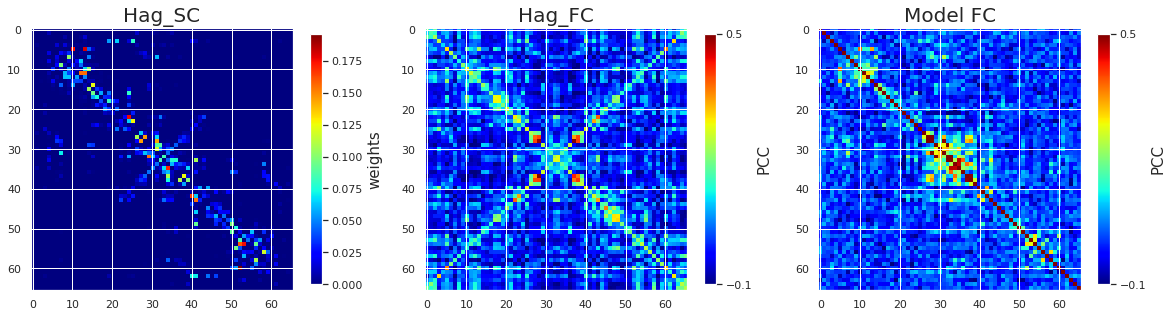

In [0]:
# Visualize the FC for the optimal G
plt.figure(figsize=(20,20))
# Hag_SC
plt.subplot(131)
plt.imshow(Hag_SC, interpolation='nearest', cmap='jet')
plt.title('Hag_SC', fontsize=20)
cb=plt.colorbar(shrink=0.23)
cb.set_label('weights', fontsize=15)

# Hag_FC
plt.subplot(132)
plt.imshow(Hag_FC, interpolation='nearest', cmap='jet')
plt.title('Hag_FC', fontsize=20)
cb=plt.colorbar(shrink=0.23, ticks=[-0.1, 0.5])
cb.set_label('PCC', fontsize=15)
plt.clim([-0.1, 0.5])

# FC model
plt.subplot(133)
plt.imshow(FC_sim_best, interpolation='nearest', cmap='jet')
plt.title('Model FC', fontsize=20)
cb=plt.colorbar(shrink=0.23, ticks=[-0.1, 0.5])
cb.set_label('PCC', fontsize=15)
plt.clim([-0.1, 0.5])

plt.show()

<h3><font size="4" face="arial" color="black">SC-FC comparisons</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">
We will plot the empirical SC matrix, the empirical FC and the model FC between one seed region and all other brain regions at the best operating point (i.e., at the edge of the second bifurcation). We take the <b>left posterior cingulate (lPC)</b> as a seed, which is part of the well-known default-mode network.
</font></div></p>

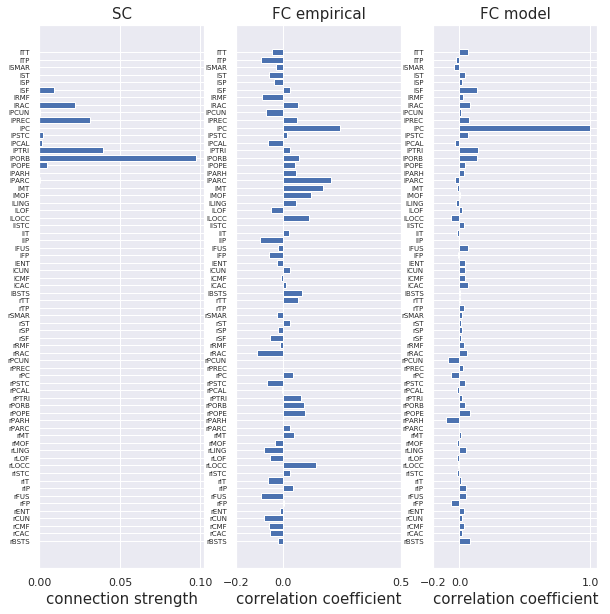

In [0]:
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.barh(np.arange(nregions), Hag_con.weights[55, :], align='center')
plt.title('SC', fontsize=15)
plt.xlabel('connection strength', fontsize=15)
plt.xticks([0., 0.05, 0.1])
plt.yticks(np.arange(nregions), Hag_con.region_labels, fontsize=7)
plt.subplot(132)
plt.barh(np.arange(nregions), Hag_FC[55, :], align='center')
plt.title('FC empirical', fontsize=15)
plt.xlabel('correlation coefficient', fontsize=15)
plt.xticks([-0.2, 0, 0.5])
plt.yticks(np.arange(nregions), Hag_con.region_labels, fontsize=7)
plt.subplot(133)
plt.barh(np.arange(nregions), FC_sim_best[55, :], align='center')
plt.title('FC model', fontsize=15)
plt.xlabel('correlation coefficient', fontsize=15)
plt.xticks([-0.2, 0, 1])
plt.yticks(np.arange(nregions), Hag_con.region_labels, fontsize=7)

plt.show()

---

<h2><font size="6" color="#609BC4">Conclusions</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">
<br>

We hope this has been a useful tutorial and welcome any comments or questions.
</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">

Further exploration:

</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">
<ul>
<li>Dynamics of Functional Connectivity?</li>
<ul>
<li>Can TVB reproduce also FCD beyond time-varying FC?</li>
<li>if yes, is the working region unchanged or not?</li>
</ul>
</ul>
<ul>
<li>Simulate a lesion?</li>
<ul>
<li>Effects of a lesion are not local and are difficult to predict without a simulation</li>
<li>How long must be the time series to see it?</li>
</ul>
</ul>

</font></div></p>

---

<h1><font size="6" color="#609BC4">References</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">
<blockquote>

Hagmann, P., Cammoun, L., Gigandet, X., Mueli, R., Honey, C.J., Wedeen, V.J., Sporns, O. (2008) <b>Mapping the structural core of human cerebral cortex.</b> PLoS Biol., 2008, 6, e159. <br />

<br>Cabral, J., Hugues, E., Sporns, O., Deco, G. (2011)<b>Role of local network oscillations in resting-state network dynamics.</b> NeuroImage, 57(2011), 130-139.<br />

<br>Desikan, R.S., Ségonne, F., Fischl, B., Quinn, B.T., Dickerson, B.C., Blacker, D., Buckner, R.L., Dale, A.M., Maguire, R.P., Hyman, B.T. Albert, M.S., Killiany, R.J. (2006)<b>An automated labeling system for subdividing the human cerebral cortex on MRI scans into gyral based regions on interest.</b> NeuroImage, 2011, 31(3), 968-980.<br />

<br>Wong, K.-F. &#38; Wang, X.-J. (2006)<b>A recurrent network  mechanism of time integration in perceptual decision.</b> J. Neurosci., 2006, 26, 1314-1328. <br />

<br>Deco, G., Ponce-Alvarez, A., Mantini, D., Romani, G.L., Hagmann, P. &#38; Corbetta, M. (2013)<b>Resting-state functional connectivity emerges from structurally and dynamically shaped slow linear fluctuations.</b> J. Neurosci., 32(27), 11239-11252, 2013.<br /> 

<br>Hansen, E.C., Battaglia, D., Spiegler, A., Deco, G. &#38; Jirsa V.K. (2015)<b>Functional connectivity dynamics: modeling the switching behavior of the resting-state.</b> NeuroImage, 105(2015), 525-535.<br />

</blockquote>
</font></font></div></p>

